# Cross-sectional analysis

- what was the situation in 2013 vs 2023? (air quality, fleet share, per country)

In [6]:
import pandas as pd

# Load processed data
aq = pd.read_csv("../data/processed/AQ_annual_averages.csv")
vehicle = pd.read_csv("../data/processed/combined_vehicle_data.csv")

# Filter for 2013 and 2023
years = [2013, 2023]
aq_13_23 = aq[aq['Year'].isin(years)]
vehicle_13_23 = vehicle[vehicle['Year'].isin(years)]

# Merge on Country and Year
merged = aq_13_23.merge(vehicle_13_23, on=['Country', 'Year'], how='left')

# Show summary: mean and std for each pollutant and year, per country
summary = (
    merged.groupby(['Country', 'Pollutant', 'Year'])
    .agg(
        AQ_Mean=('AnnualAvg_fullweek_Daytime', 'mean'),
        AQ_Std=('AnnualAvg_fullweek_Daytime', 'std'),
        AF_Fleet=('AF_fleet', 'mean'),
        BEV_Fleet=('BEV_fleet', 'mean')
    )
    .reset_index()
)

print(summary)

# Optional: Pivot for easier comparison
pivot = summary.pivot(index=['Country', 'Pollutant'], columns='Year', values=['AQ_Mean', 'AF_Fleet', 'BEV_Fleet'])
pivot

   Country   Pollutant  Year    AQ_Mean  AQ_Std  AF_Fleet  BEV_Fleet
0       AT         CO2  2013  58.166490     NaN      0.13       0.04
1       AT         CO2  2023  67.757104     NaN      4.23       3.00
2       AT          NO  2013  20.149209     NaN      0.13       0.04
3       AT          NO  2023  13.839310     NaN      4.23       3.00
4       AT         NO2  2013  26.101747     NaN      0.13       0.04
5       AT         NO2  2023  16.279895     NaN      4.23       3.00
6       AT  NOX as NO2  2013  10.692693     NaN      0.13       0.04
7       AT  NOX as NO2  2023   8.111752     NaN      4.23       3.00
8       AT        PM10  2013   4.286946     NaN      0.13       0.04
9       AT        PM10  2023   2.078151     NaN      4.23       3.00
10      CH         CO2  2023  59.021179     NaN      5.62       3.33
11      CH         NO2  2023  20.796202     NaN      5.62       3.33
12      CH        PM10  2023   8.188244     NaN      5.62       3.33
13      CH       PM2.5  2023  35.4

AQ_Mean            AF_Fleet        BEV_Fleet       
Year                     2013       2023     2013   2023      2013   2023
Country Pollutant                                                        
AT      CO2         58.166490  67.757104     0.13   4.23      0.04   3.00
        NO          20.149209  13.839310     0.13   4.23      0.04   3.00
        NO2         26.101747  16.279895     0.13   4.23      0.04   3.00
        NOX as NO2  10.692693   8.111752     0.13   4.23      0.04   3.00
        PM10         4.286946   2.078151     0.13   4.23      0.04   3.00
CH      CO2               NaN  59.021179      NaN   5.62       NaN   3.33
        NO2               NaN  20.796202      NaN   5.62       NaN   3.33
        PM10              NaN   8.188244      NaN   5.62       NaN   3.33
        PM2.5             NaN  35.476834      NaN   5.62       NaN   3.33
DK      CO2               NaN  60.690282      NaN  11.31       NaN   7.00
        NO                NaN  21.243517      NaN  11.31       NaN   7.00
        NO2               NaN  15.742592      NaN  11.31       NaN   7.00
        NOX as NO2        NaN   6.674195      NaN  11.31       NaN   7.00
        PM10         3.429345  11.749182     0.06  11.31      0.06   7.00
        PM2.5             NaN  38.988626      NaN  11.31       NaN   7.00
NL      CO2         45.950985  58.033092     2.99   9.10      0.05   4.95
        NO          21.014644  15.729163     2.99   9.10      0.05   4.95
        NO2               NaN  19.396713      NaN   9.10       NaN   4.95
        NOX as NO2  11.353653   7.582390     2.99   9.10      0.05   4.95
        PM10              NaN   6.295661      NaN   9.10       NaN   4.95
        PM2.5             NaN  30.281988      NaN   9.10       NaN   4.95
NO      CO2         42.594027  50.795713     0.66  28.11      0.62  22.01
        NO          18.495385  12.889793     0.66  28.11      0.62  22.01
        NO2         34.847818  21.485718     0.66  28.11      0.62  22.01
        NOX as NO2   9.577014   5.953912     0.66  28.11      0.62  22.01
        PM10        14.931768   9.322129     0.66  28.11      0.62  22.01
        PM2.5       66.236711  38.299727     0.66  28.11      0.62  22.01

Saved: ../figures\CO2_first_vs_last_year_by_country.png


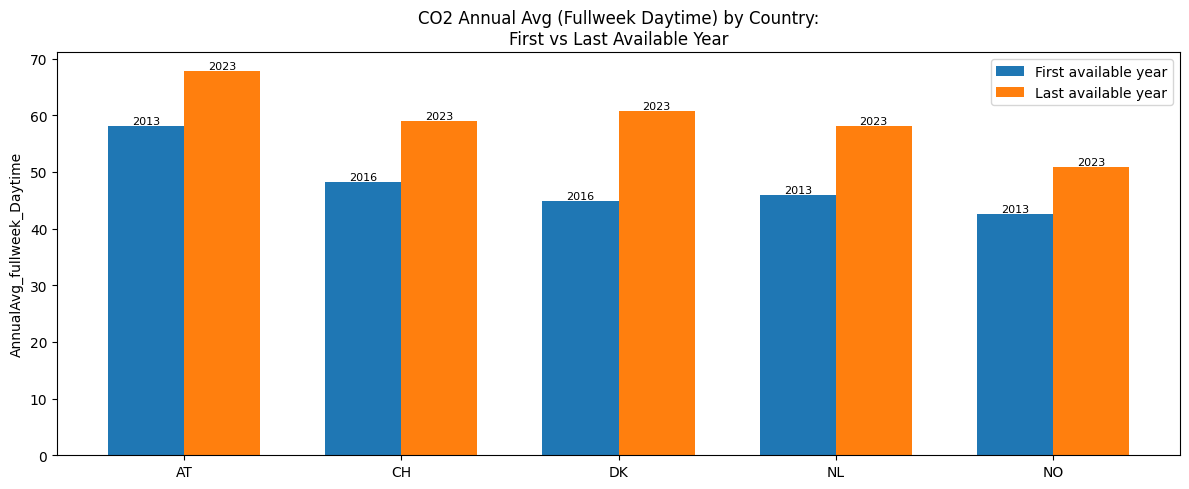

Saved: ../figures\NO2_first_vs_last_year_by_country.png


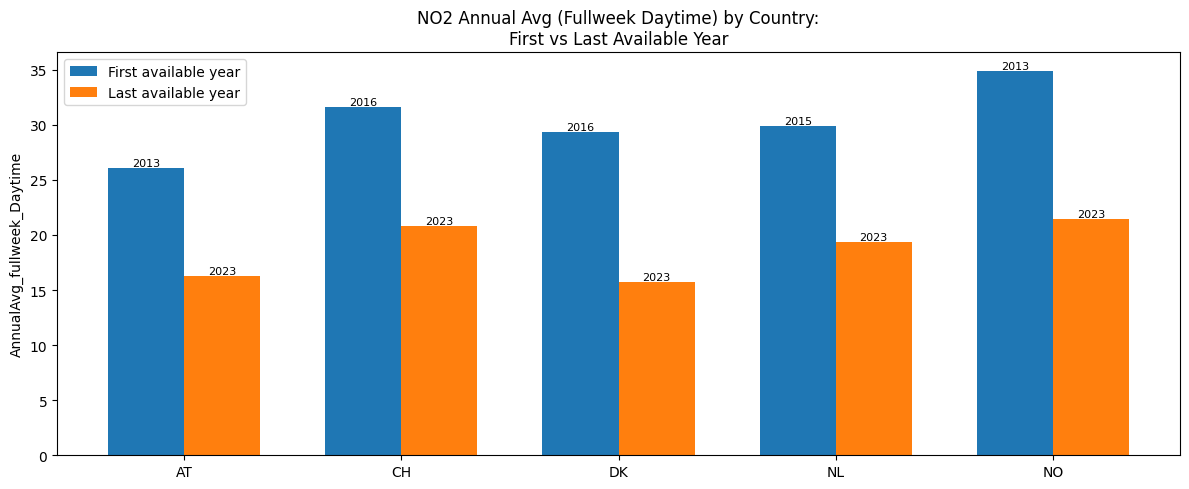

Saved: ../figures\PM2.5_first_vs_last_year_by_country.png


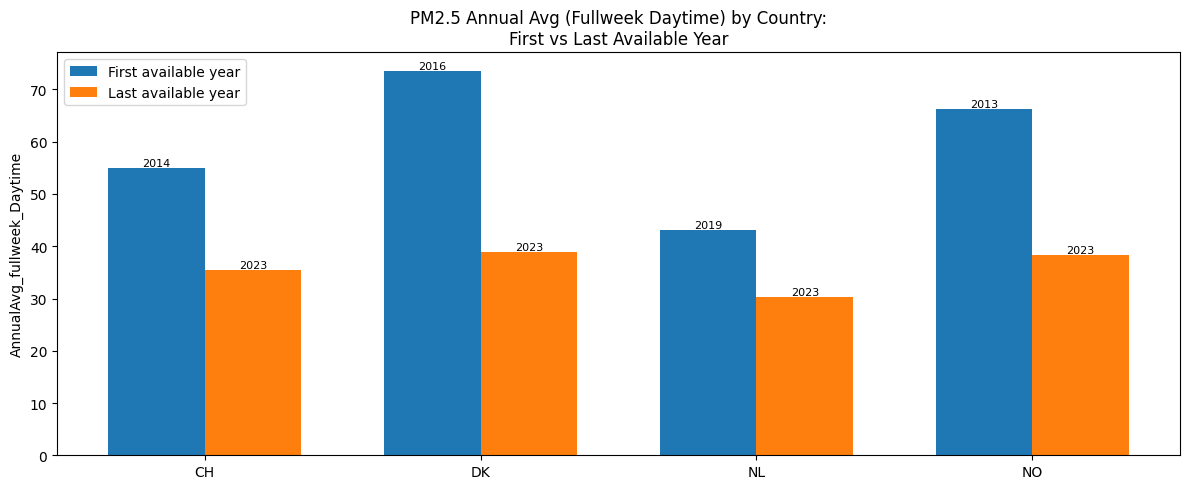

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load data
aq = pd.read_csv("../data/processed/AQ_annual_averages.csv")

# Pollutants to plot
pollutants_to_plot = ["CO2", "NO2", "PM2.5"]

# Ensure figures directory exists
figures_dir = "../figures"
os.makedirs(figures_dir, exist_ok=True)

# Find first and last available year per country and pollutant
first_last = (
    aq[aq['Pollutant'].isin(pollutants_to_plot)]
    .groupby(['Country', 'Pollutant'])['Year']
    .agg(['min', 'max'])
    .reset_index()
)

# Prepare data for plotting
for pollutant in pollutants_to_plot:
    plt.figure(figsize=(12, 5))
    sub = first_last[first_last['Pollutant'] == pollutant]
    countries = sub['Country'].unique()
    x = range(len(countries))
    width = 0.35

    vals_first = []
    vals_last = []
    years_first = []
    years_last = []
    for _, row in sub.iterrows():
        y_first = aq[(aq['Country'] == row['Country']) & (aq['Pollutant'] == pollutant) & (aq['Year'] == row['min'])]['AnnualAvg_fullweek_Daytime']
        y_last = aq[(aq['Country'] == row['Country']) & (aq['Pollutant'] == pollutant) & (aq['Year'] == row['max'])]['AnnualAvg_fullweek_Daytime']
        vals_first.append(y_first.values[0] if not y_first.empty else None)
        vals_last.append(y_last.values[0] if not y_last.empty else None)
        years_first.append(row['min'])
        years_last.append(row['max'])

    plt.bar([i - width/2 for i in x], vals_first, width, label='First available year')
    plt.bar([i + width/2 for i in x], vals_last, width, label='Last available year')

    # Annotate bars with years
    for i, (y, year) in enumerate(zip(vals_first, years_first)):
        if pd.notnull(y):
            plt.text(i - width/2, y, str(year), ha='center', va='bottom', fontsize=8, rotation=0)
    for i, (y, year) in enumerate(zip(vals_last, years_last)):
        if pd.notnull(y):
            plt.text(i + width/2, y, str(year), ha='center', va='bottom', fontsize=8, rotation=0)

    plt.xticks(x, countries)
    plt.ylabel('AnnualAvg_fullweek_Daytime')
    plt.title(f'{pollutant} Annual Avg (Fullweek Daytime) by Country:\nFirst vs Last Available Year')
    plt.legend()
    plt.tight_layout()

    # Save figure if not already present
    fig_path = os.path.join(figures_dir, f"{pollutant}_first_vs_last_year_by_country.png")
    if not os.path.exists(fig_path):
        plt.savefig(fig_path)
        print(f"Saved: {fig_path}")
    else:
        print(f"Figure already exists: {fig_path}")
    plt.show()

# Regression models


OLS summary for NO - CO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.461
Model:                                    OLS   Adj. R-squared:                  0.401
Method:                         Least Squares   F-statistic:                     7.690
Date:                        Sat, 17 May 2025   Prob (F-statistic):             0.0216
Time:                                12:43:51   Log-Likelihood:                -29.031
No. Observations:                          11   AIC:                             62.06
Df Residuals:                               9   BIC:                             62.86
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

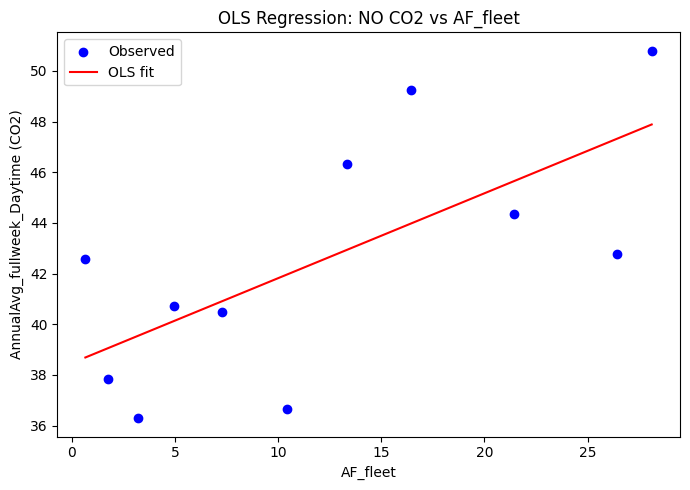


OLS summary for NO - NO:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.552
Model:                                    OLS   Adj. R-squared:                  0.503
Method:                         Least Squares   F-statistic:                     11.10
Date:                        Sat, 17 May 2025   Prob (F-statistic):            0.00877
Time:                                12:43:52   Log-Likelihood:                -15.928
No. Observations:                          11   AIC:                             35.86
Df Residuals:                               9   BIC:                             36.65
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

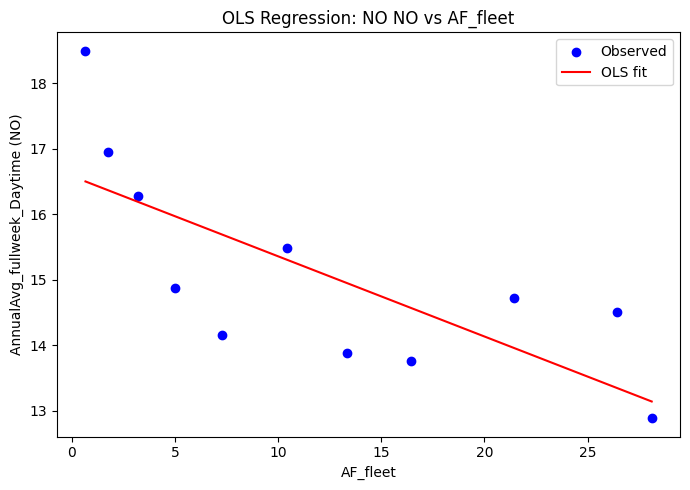


OLS summary for NO - NO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.889
Model:                                    OLS   Adj. R-squared:                  0.877
Method:                         Least Squares   F-statistic:                     72.21
Date:                        Sat, 17 May 2025   Prob (F-statistic):           1.36e-05
Time:                                12:43:52   Log-Likelihood:                -20.885
No. Observations:                          11   AIC:                             45.77
Df Residuals:                               9   BIC:                             46.57
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

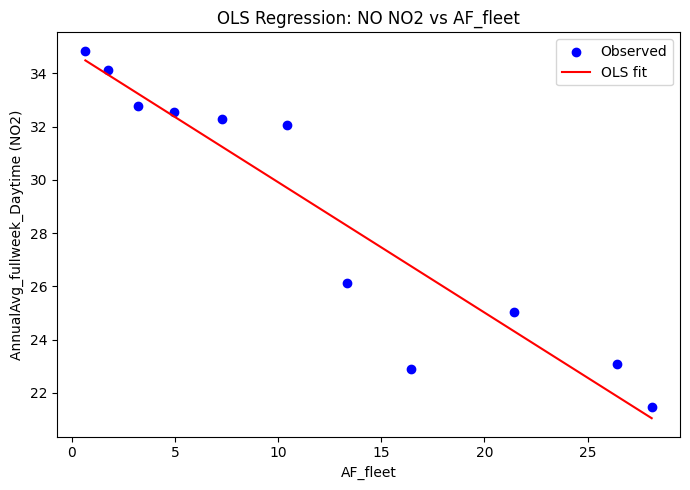


OLS summary for NO - NOX as NO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.572
Model:                                    OLS   Adj. R-squared:                  0.525
Method:                         Least Squares   F-statistic:                     12.03
Date:                        Sat, 17 May 2025   Prob (F-statistic):            0.00706
Time:                                12:43:52   Log-Likelihood:                -12.222
No. Observations:                          11   AIC:                             28.44
Df Residuals:                               9   BIC:                             29.24
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

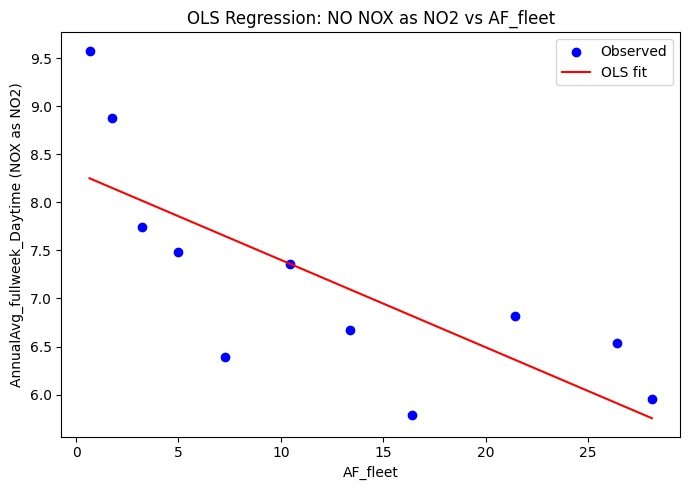


OLS summary for NO - PM10:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.843
Model:                                    OLS   Adj. R-squared:                  0.826
Method:                         Least Squares   F-statistic:                     48.32
Date:                        Sat, 17 May 2025   Prob (F-statistic):           6.67e-05
Time:                                12:43:53   Log-Likelihood:                -13.164
No. Observations:                          11   AIC:                             30.33
Df Residuals:                               9   BIC:                             31.12
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

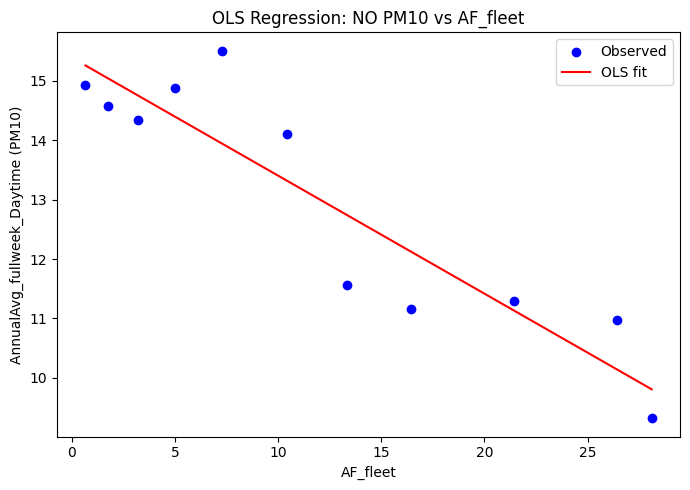


OLS summary for NO - PM2.5:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.912
Model:                                    OLS   Adj. R-squared:                  0.902
Method:                         Least Squares   F-statistic:                     92.77
Date:                        Sat, 17 May 2025   Prob (F-statistic):           4.89e-06
Time:                                12:43:53   Log-Likelihood:                -27.209
No. Observations:                          11   AIC:                             58.42
Df Residuals:                               9   BIC:                             59.21
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

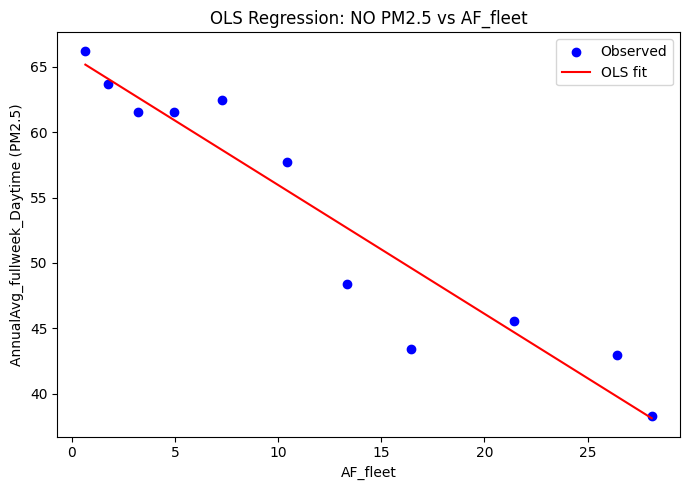

In [10]:
# OLS for all pollutants in Norway: AF_fleet as X, annual average as Y
import statsmodels.api as sm
import matplotlib.pyplot as plt

country = "NO"
pollutants = data[data["Country"] == country]["Pollutant"].unique()

for pollutant in pollutants:
    df = data[(data["Country"] == country) & (data["Pollutant"] == pollutant)].copy()
    annual_avg_cols = [col for col in df.columns if "AnnualAvg" in col]
    if not annual_avg_cols or "AF_fleet" not in df.columns:
        print(f"Skipping {pollutant}: missing columns.")
        continue
    target_col = annual_avg_cols[0]
    df = df.sort_values("AF_fleet")
    X = df["AF_fleet"].astype(float)
    y = df[target_col].astype(float)
    mask = y.notnull() & X.notnull()
    X = X[mask]
    y = y[mask]
    X_ols = sm.add_constant(X)
    model = sm.OLS(y, X_ols).fit()
    print(f"\nOLS summary for {country} - {pollutant}:")
    print(model.summary())
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, label="Observed", color="blue")
    plt.plot(X, model.predict(X_ols), color="red", label="OLS fit")
    plt.xlabel("AF_fleet")
    plt.ylabel(f"{target_col} ({pollutant})")
    plt.title(f"OLS Regression: {country} {pollutant} vs AF_fleet")
    plt.legend()
    plt.tight_layout()
    plt.show()


OLS summary for ALL COUNTRIES - CO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.071
Model:                                    OLS   Adj. R-squared:                  0.050
Method:                         Least Squares   F-statistic:                     3.437
Date:                        Sat, 17 May 2025   Prob (F-statistic):             0.0703
Time:                                12:45:05   Log-Likelihood:                -165.42
No. Observations:                          47   AIC:                             334.8
Df Residuals:                              45   BIC:                             338.5
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

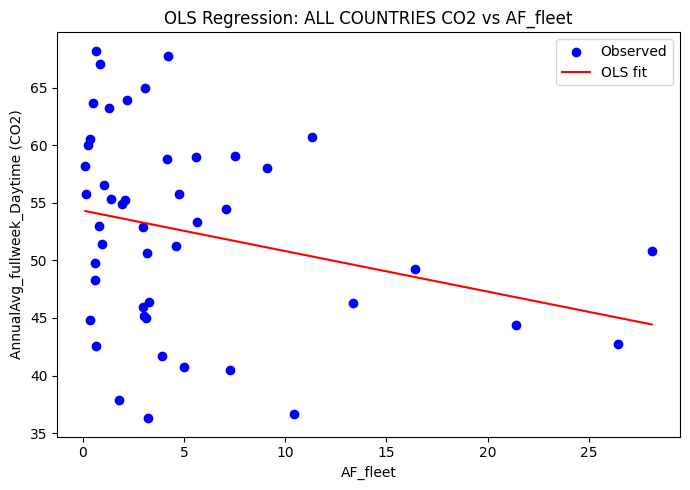


OLS summary for ALL COUNTRIES - NO:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.214
Model:                                    OLS   Adj. R-squared:                  0.193
Method:                         Least Squares   F-statistic:                     10.34
Date:                        Sat, 17 May 2025   Prob (F-statistic):            0.00266
Time:                                12:45:06   Log-Likelihood:                -97.845
No. Observations:                          40   AIC:                             199.7
Df Residuals:                              38   BIC:                             203.1
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

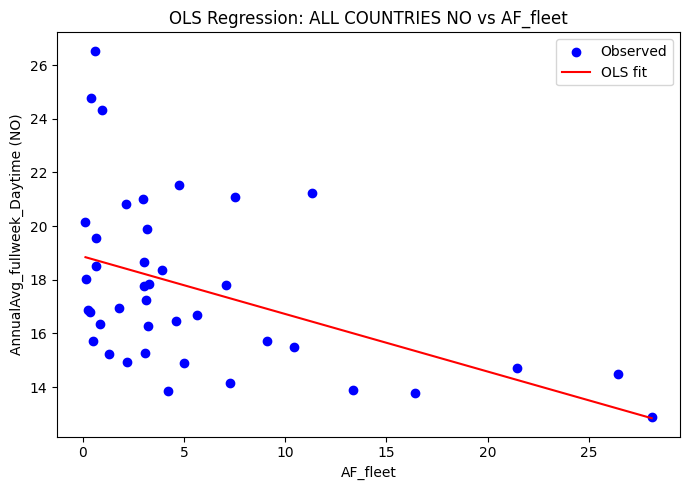


OLS summary for ALL COUNTRIES - NO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.035
Model:                                    OLS   Adj. R-squared:                  0.013
Method:                         Least Squares   F-statistic:                     1.577
Date:                        Sat, 17 May 2025   Prob (F-statistic):              0.216
Time:                                12:45:06   Log-Likelihood:                -140.42
No. Observations:                          46   AIC:                             284.8
Df Residuals:                              44   BIC:                             288.5
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

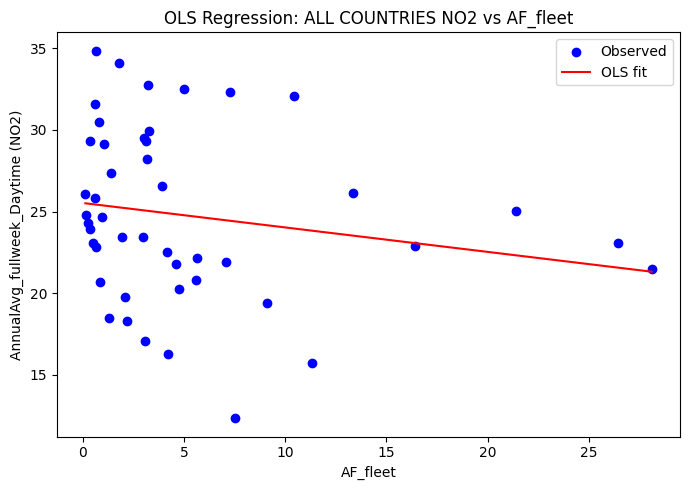


OLS summary for ALL COUNTRIES - NOX as NO2:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.470
Model:                                    OLS   Adj. R-squared:                  0.456
Method:                         Least Squares   F-statistic:                     32.80
Date:                        Sat, 17 May 2025   Prob (F-statistic):           1.47e-06
Time:                                12:45:07   Log-Likelihood:                -59.151
No. Observations:                          39   AIC:                             122.3
Df Residuals:                              37   BIC:                             125.6
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

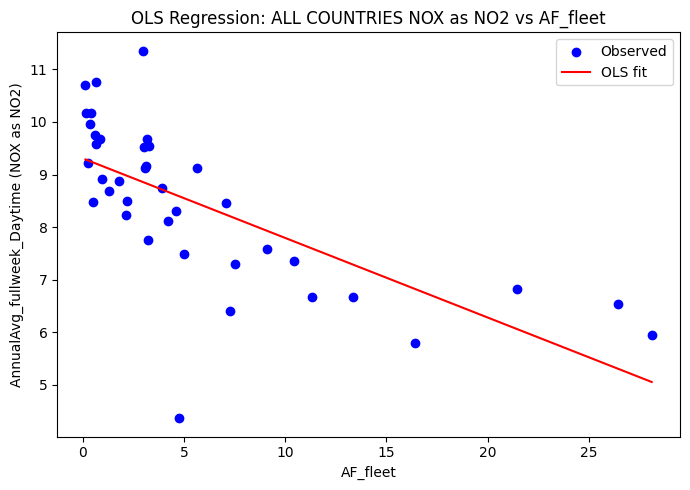


OLS summary for ALL COUNTRIES - PM10:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.054
Model:                                    OLS   Adj. R-squared:                  0.033
Method:                         Least Squares   F-statistic:                     2.616
Date:                        Sat, 17 May 2025   Prob (F-statistic):              0.113
Time:                                12:45:07   Log-Likelihood:                -136.70
No. Observations:                          48   AIC:                             277.4
Df Residuals:                              46   BIC:                             281.2
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

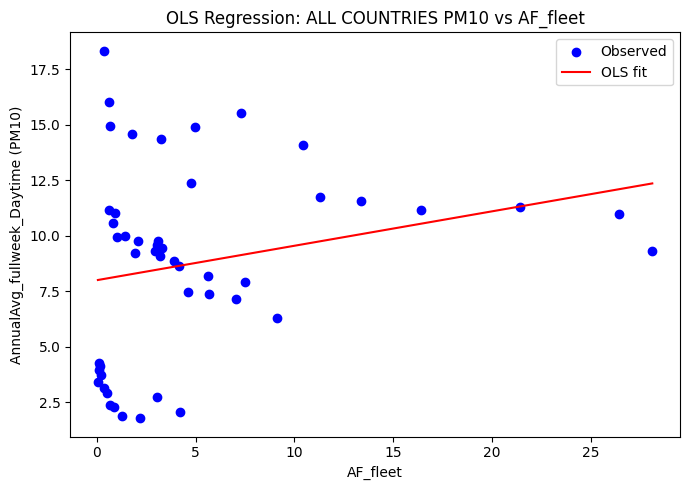


OLS summary for ALL COUNTRIES - PM2.5:
                                OLS Regression Results                                
Dep. Variable:     AnnualAvg_fullweek_Daytime   R-squared:                       0.139
Model:                                    OLS   Adj. R-squared:                  0.111
Method:                         Least Squares   F-statistic:                     4.992
Date:                        Sat, 17 May 2025   Prob (F-statistic):             0.0328
Time:                                12:45:07   Log-Likelihood:                -124.48
No. Observations:                          33   AIC:                             253.0
Df Residuals:                              31   BIC:                             256.0
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

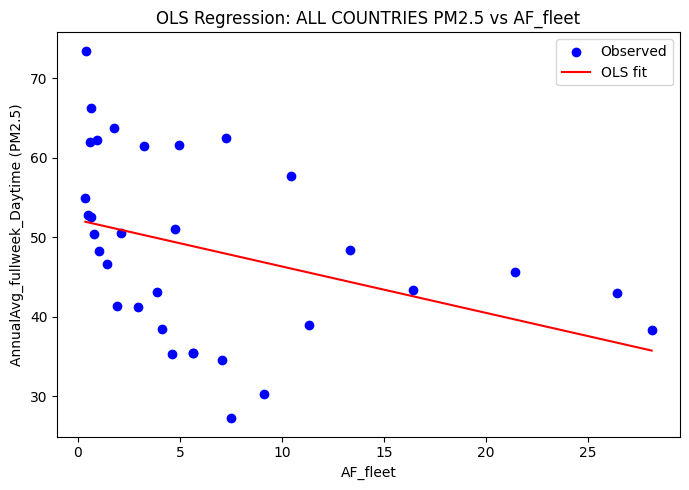

In [11]:
# OLS for all pollutants, all countries: AF_fleet as X, annual average as Y
import statsmodels.api as sm
import matplotlib.pyplot as plt

pollutants = data["Pollutant"].unique()

for pollutant in pollutants:
    df = data[data["Pollutant"] == pollutant].copy()
    annual_avg_cols = [col for col in df.columns if "AnnualAvg" in col]
    if not annual_avg_cols or "AF_fleet" not in df.columns:
        print(f"Skipping {pollutant}: missing columns.")
        continue
    target_col = annual_avg_cols[0]
    df = df.sort_values("AF_fleet")
    X = df["AF_fleet"].astype(float)
    y = df[target_col].astype(float)
    mask = y.notnull() & X.notnull()
    X = X[mask]
    y = y[mask]
    X_ols = sm.add_constant(X)
    model = sm.OLS(y, X_ols).fit()
    print(f"\nOLS summary for ALL COUNTRIES - {pollutant}:")
    print(model.summary())
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, label="Observed", color="blue")
    plt.plot(X, model.predict(X_ols), color="red", label="OLS fit")
    plt.xlabel("AF_fleet")
    plt.ylabel(f"{target_col} ({pollutant})")
    plt.title(f"OLS Regression: ALL COUNTRIES {pollutant} vs AF_fleet")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# ...existing code...

# Filter for one country and three pollutants
country = "NO"
pollutants = ["CO2", "NO2", "NO"]
data = data[(data["Country"] == country) & (data["Pollutant"].isin(pollutants))]

output_dir = "../results"
results_list = []
fig_dir = "../figures"
os.makedirs(fig_dir, exist_ok=True)

print("Filtered data shape:", data.shape)
print("Countries:", data['Country'].unique())
print("Pollutants:", data['Pollutant'].unique())
print("Feature columns:", feature_cols)
print("Target columns:", target_cols)

# 1) Aggregate across all years per pollutant
for pollutant in data['Pollutant'].unique():
    pollutant_data = data[data['Pollutant'] == pollutant]
    best_r2 = -np.inf
    best_model = None
    best_feature = None
    best_target = None
    best_X_test = None
    best_y_test = None
    best_y_pred = None
    for target in target_cols:
        for feature in feature_cols:
            X = pollutant_data[[feature]]
            y = pollutant_data[target]
            mask = y.notnull() & X[feature].notnull()
            print(f"Pollutant: {pollutant}, Target: {target}, Feature: {feature}, Valid rows: {mask.sum()}")
            if mask.sum() < 5:
                continue
            X_train, X_test, y_train, y_test = train_test_split(X[mask], y[mask], test_size=0.2, random_state=42)
            reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            models = models.reset_index().rename(columns={'index': 'Model'})
            models['Pollutant'] = pollutant
            models['Target'] = target
            models['Feature'] = feature
            results_list.append(models)
            # Find R2 column dynamically
            r2_col = None
            for col in models.columns:
                if 'r2' in col.lower():
                    r2_col = col
                    break
            if r2_col is not None and models.loc[0, r2_col] > best_r2:
                best_r2 = models.loc[0, r2_col]
                best_model_name = models.loc[0, 'Model']
                best_model = reg.models[best_model_name]
                best_feature = feature
                best_target = target
                best_X_test = X_test
                best_y_test = y_test
                best_y_pred = best_model.predict(X_test)
    # Plot only the very best model for this pollutant
    if best_model is not None:
        plt.figure(figsize=(7, 7))
        plt.scatter(best_y_test, best_y_pred, alpha=0.7)
        z = np.polyfit(best_y_test, best_y_pred, 1)
        p = np.poly1d(z)
        plt.plot(best_y_test, p(best_y_test), "b--", label="Regression line")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Best: {best_model_name}\n{country} - {pollutant} - {best_target} vs {best_feature}\nR2={best_r2:.2f}")
        plt.plot([best_y_test.min(), best_y_test.max()], [best_y_test.min(), best_y_test.max()], 'r--', label="Ideal")
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, f"bestmodel_{country}_{pollutant}_aggregate.png"))
        plt.close()

# 2) Per year, aggregate for each pollutant
for pollutant in data['Pollutant'].unique():
    pollutant_data = data[data['Pollutant'] == pollutant]
    for year in pollutant_data['Year'].unique():
        year_data = pollutant_data[pollutant_data['Year'] == year]
        best_r2 = -np.inf
        best_model = None
        best_feature = None
        best_target = None
        best_X_test = None
        best_y_test = None
        best_y_pred = None
        for target in target_cols:
            for feature in feature_cols:
                X = year_data[[feature]]
                y = year_data[target]
                mask = y.notnull() & X[feature].notnull()
                print(f"Year: {year}, Pollutant: {pollutant}, Target: {target}, Feature: {feature}, Valid rows: {mask.sum()}")
                if mask.sum() < 5:
                    continue
                X_train, X_test, y_train, y_test = train_test_split(X[mask], y[mask], test_size=0.2, random_state=42)
                reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
                models, predictions = reg.fit(X_train, X_test, y_train, y_test)
                models = models.reset_index().rename(columns={'index': 'Model'})
                models['Pollutant'] = pollutant
                models['Target'] = target
                models['Feature'] = feature
                models['Year'] = year
                results_list.append(models)
                r2_col = None
                for col in models.columns:
                    if 'r2' in col.lower():
                        r2_col = col
                        break
                if r2_col is not None and models.loc[0, r2_col] > best_r2:
                    best_r2 = models.loc[0, r2_col]
                    best_model_name = models.loc[0, 'Model']
                    best_model = reg.models[best_model_name]
                    best_feature = feature
                    best_target = target
                    best_X_test = X_test
                    best_y_test = y_test
                    best_y_pred = best_model.predict(X_test)
        # Plot only the very best model for this pollutant/year
        if best_model is not None:
            plt.figure(figsize=(7, 7))
            plt.scatter(best_y_test, best_y_pred, alpha=0.7)
            z = np.polyfit(best_y_test, best_y_pred, 1)
            p = np.poly1d(z)
            plt.plot(best_y_test, p(best_y_test), "b--", label="Regression line")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title(f"Best: {best_model_name}\n{country} - {pollutant} ({year}) - {best_target} vs {best_feature}\nR2={best_r2:.2f}")
            plt.plot([best_y_test.min(), best_y_test.max()], [best_y_test.min(), best_y_test.max()], 'r--', label="Ideal")
            plt.tight_layout()
            plt.savefig(os.path.join(fig_dir, f"bestmodel_{country}_{pollutant}_{year}.png"))
            plt.show()
            plt.close()

# Save all model results
if results_list:
    all_results = pd.concat(results_list, ignore_index=True)
    all_results.to_csv(os.path.join(output_dir, "model_results_summary.csv"), index=False)
    print("Saved all model results to model_results_summary.csv")
else:
    print("No valid model runs: check your data and thresholds!")